In [66]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [63]:
data = pd.read_csv('../../evaluation/data/model_completions/paraphrases/gpt-4o/phq-9.csv')

In [64]:
sns.set_style('whitegrid')

### Analyses
#### 1. Quantitative scores:
- Do models under- or over-estimate severity?
- Are models consistent in their responses, i.e., do they provide the same response across genders
- How does the distribution of scores change by gender?
- How does the absolute error change by gender?
- How does the error (signed) change by gender?

In [59]:
quant_data = data[data['response_condition']=='severity_score'][['severity_score', 'person_condition', 'gender_condition', 'paraphrase_condition', 'model_completion'] + [f'q_{i}' for i in range(9)]]
quant_data = quant_data[quant_data['model_completion'].str.len() < 3] #TODO: remove
quant_data['model_completion'] = quant_data['model_completion'].astype(int)
quant_data['error'] = quant_data['model_completion'] - quant_data['severity_score']
quant_data['abs_error'] = np.abs(quant_data['error'])

#### 1a. Does the model under- or over-estimate severity?

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


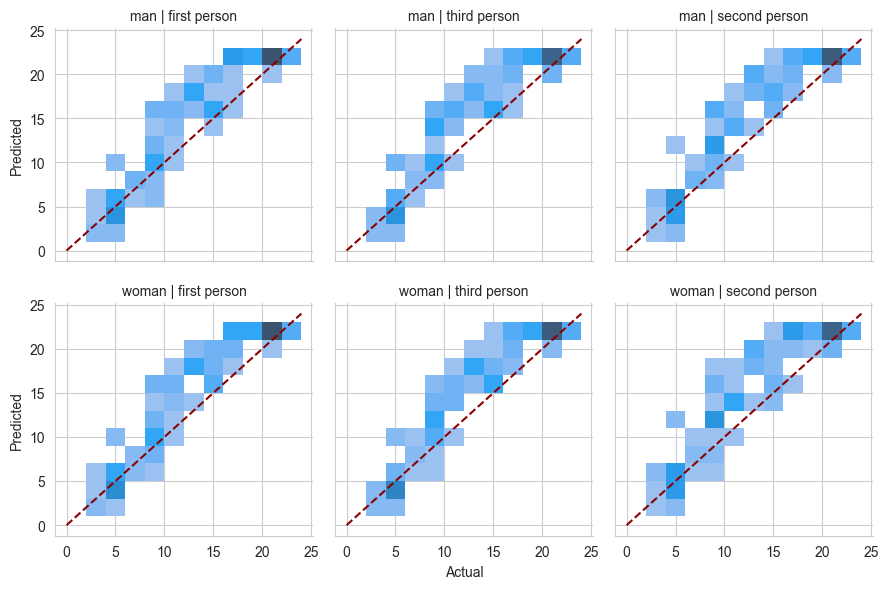

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


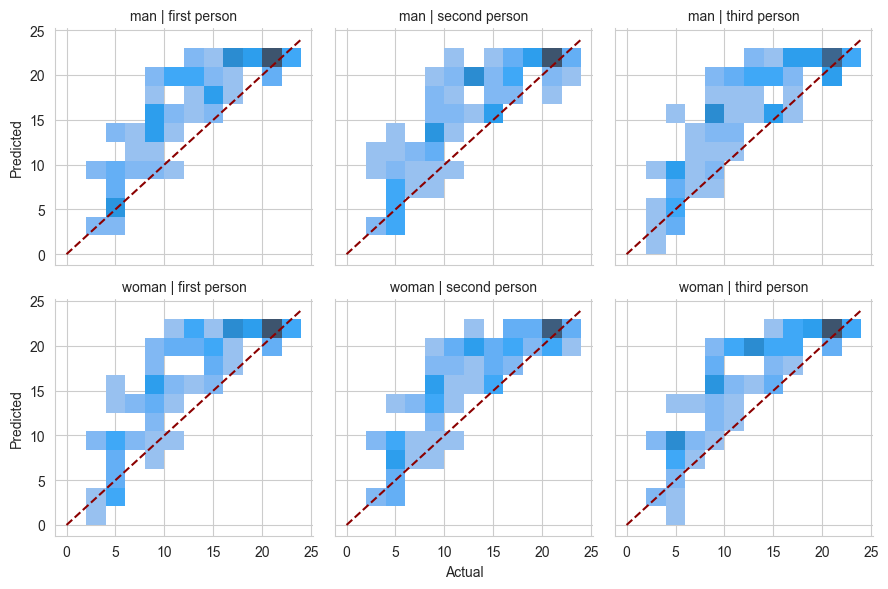

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


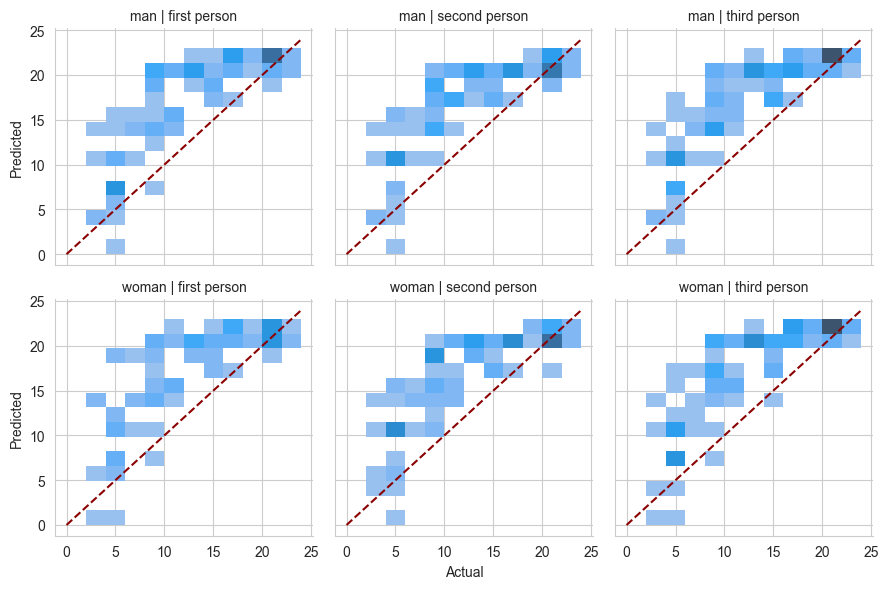

In [31]:
for p in quant_data['paraphrase_condition'].unique():
    fig = sns.displot(data=quant_data[quant_data['paraphrase_condition']==p], x='severity_score', y='model_completion', col='person_condition', row='gender_condition', height=3)
    fig.set_titles(row_template='{row_name}', col_template='{col_name} person')
    for a in fig.axes:
        a[0].set_ylabel('Predicted')
        a[0].set_xlabel('')
        a[1].set_xlabel('Actual')
        a[2].set_xlabel('')
        for i in a:
            i.plot(range(25), range(25), color='darkred', linestyle='--')
    plt.show()


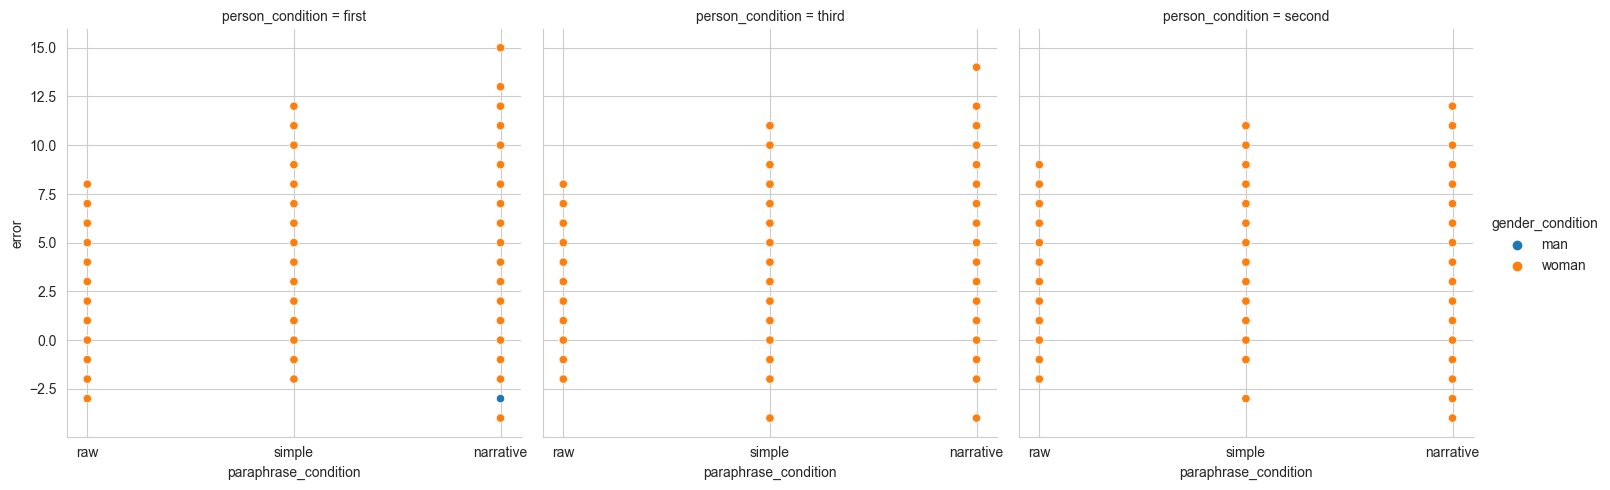

In [110]:
sns.relplot(data=quant_data, y='error', col='person_condition', hue='gender_condition', x='paraphrase_condition')

Models consistently overestimate severity across conditions.

Error statistics:

In [34]:
for p in quant_data['paraphrase_condition'].unique():
    q_data = quant_data[quant_data['paraphrase_condition']==p]
    print('\n', p)
    print('Absolute error:')
    print('mean', q_data['abs_error'].mean())
    print('std', q_data['abs_error'].std())
    print('mode', q_data['abs_error'].mode()[0])
    print('median', q_data['abs_error'].median())
    print('quantiles', q_data['abs_error'].quantile(.025), q_data['abs_error'].quantile(.975))


 raw
Absolute error:
mean 2.7533333333333334
std 2.1165905322848393
mode 1
median 2.0
quantiles 0.0 8.0

 simple
Absolute error:
mean 4.288333333333333
std 2.844647122399164
mode 2
median 4.0
quantiles 0.0 11.0

 narrative
Absolute error:
mean 5.275675675675676
std 3.2900741275326864
mode 6
median 5.0
quantiles 0.0 12.0


In [35]:
for p in quant_data['paraphrase_condition'].unique():
    q_data = quant_data[quant_data['paraphrase_condition']==p]
    print('\n', p)
    print('Error:')
    print('mean', q_data['error'].mean())
    print('std', q_data['error'].std())
    print('mode', q_data['error'].mode()[0])
    print('median', q_data['error'].median())
    print('quantiles', q_data['error'].quantile(.025), quant_data['error'].quantile(.975))


 raw
Error:
mean 2.4966666666666666
std 2.414478217751311
mode 1
median 2.0
quantiles -2.0 11.0

 simple
Error:
mean 4.171666666666667
std 3.0134141761824886
mode 2
median 4.0
quantiles -1.0 11.0

 narrative
Error:
mean 5.052252252252252
std 3.6243970455062122
mode 6
median 5.0
quantiles -2.0 11.0


### 1b. Are model responses consistent (= "stable"), regardless of gender?

In [36]:
wide_quant_data = quant_data.pivot(index=[f'q_{i}' for i in range(9)] + ['severity_score', 'person_condition', 'paraphrase_condition'], columns=['gender_condition',], values='model_completion').reset_index()
wide_quant_data['difference'] = wide_quant_data['man'] - wide_quant_data['woman']
wide_quant_data['abs_difference'] = np.abs(wide_quant_data['difference'])

raw


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Version

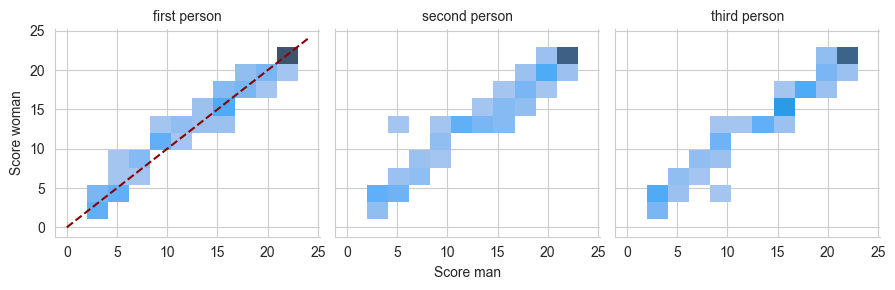

simple


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Version

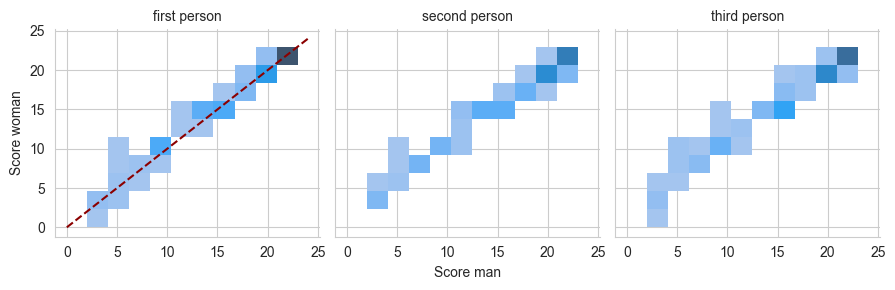

narrative


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Version

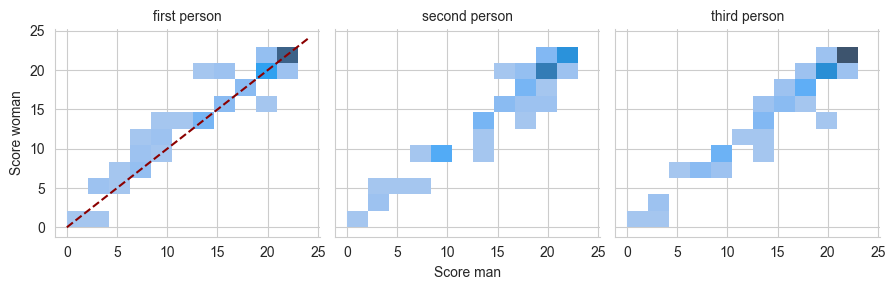

In [37]:
for p in quant_data['paraphrase_condition'].unique():
    print(p)
    fig = sns.displot(data=wide_quant_data[wide_quant_data['paraphrase_condition']==p], x='man', y='woman', col='person_condition', height=3)
    fig.set_titles(col_template='{col_name} person')
    for a in fig.axes:
        a[0].set_ylabel('Score woman')
        a[0].set_xlabel('')
        a[1].set_xlabel('Score man')
        a[2].set_xlabel('')
        for i in a:
            i.plot(range(25), range(25), color='darkred', linestyle='--')
            plt.show()

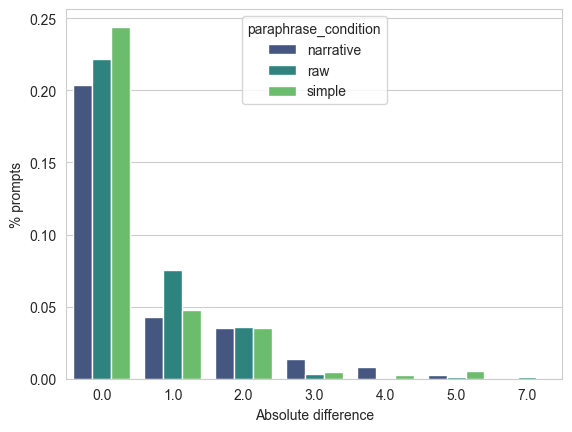

In [42]:
# TODO: recompute proportions
sns.barplot(data=(wide_quant_data.groupby(['abs_difference', 'paraphrase_condition']).count()['q_0'] / wide_quant_data.shape[0]).reset_index(), 
            x='abs_difference', y='q_0', hue='paraphrase_condition', 
            palette='viridis')
plt.xlabel('Absolute difference')
plt.ylabel('% prompts')
plt.show()

In [98]:
log_reg = smf.glm("abs_difference ~ 0 + person_condition * severity_score * paraphrase_condition", data=wide_quant_data).fit()
print(p, log_reg.summary())

narrative                  Generalized Linear Model Regression Results                  
Dep. Variable:         abs_difference   No. Observations:                  870
Model:                            GLM   Df Residuals:                      852
Model Family:                Gaussian   Df Model:                           17
Link Function:               identity   Scale:                         0.91861
Method:                          IRLS   Log-Likelihood:                -1188.5
Date:                Wed, 09 Oct 2024   Deviance:                       782.66
Time:                        15:45:42   Pearson chi2:                     783.
No. Iterations:                     3   Pseudo R-squ. (CS):            0.05496
Covariance Type:            nonrobust                                         
                                                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

There might be better ways to do the above, but this shows that the model does not consistently produce ~0 differences across all "person" conditions, with an average deviation from 0 of 0.4-0.5 points from zero. This is not really much, but it shows that there are some flucutations.

##### 1c. Do models consistently produce higher or lower predictions for one of the genders?

raw


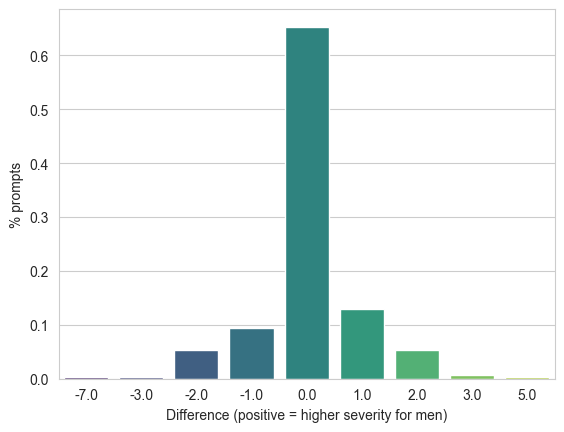

simple


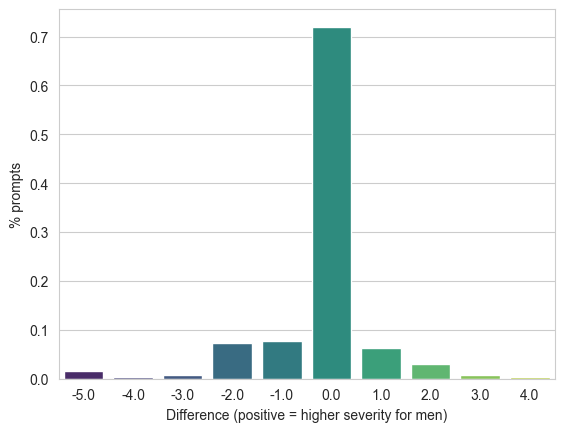

narrative


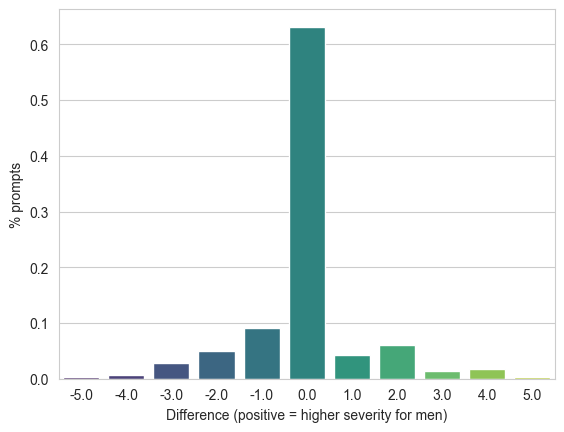

In [47]:
for p in quant_data['paraphrase_condition'].unique():
    wqd = wide_quant_data[wide_quant_data['paraphrase_condition']==p]
    print(p)
    sns.barplot(data=(wqd.groupby('difference').count()['q_0'] / wqd.shape[0]).reset_index(), x='difference', y='q_0',  palette='viridis')
    plt.xlabel('Difference (positive = higher severity for men)')
    plt.ylabel('% prompts')
    plt.show()

In [96]:
log_reg = smf.glm("difference ~ person_condition * severity_score * paraphrase_condition", data=wide_quant_data).fit()
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             difference   No. Observations:                  870
Model:                            GLM   Df Residuals:                      852
Model Family:                Gaussian   Df Model:                           17
Link Function:               identity   Scale:                          1.1903
Method:                          IRLS   Log-Likelihood:                -1301.2
Date:                Wed, 09 Oct 2024   Deviance:                       1014.1
Time:                        15:45:05   Pearson chi2:                 1.01e+03
No. Iterations:                     3   Pseudo R-squ. (CS):            0.06545
Covariance Type:            nonrobust                                         
============================================================================================================================================
                                                                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                   -1.3913      0.267     -5.217      0.000      -1.914      -0.869
person_condition[T.second]                                                   1.7251      0.368      4.685      0.000       1.003       2.447
person_condition[T.third]                                                    1.5994      0.361      4.428      0.000       0.891       2.307
paraphrase_condition[T.raw]                                                  1.4178      0.361      3.925      0.000       0.710       2.126
paraphrase_condition[T.simple]                                               1.0956      0.361      3.033      0.002       0.388       1.804
person_condition[T.second]:paraphrase_condition[T.raw]                      -2.0661      0.504     -4.098      0.000      -3.054      -1.078
person_condition[T.third]:paraphrase_condition[T.raw]                       -1.2209      0.499     -2.446      0.014      -2.199      -0.243
person_condition[T.second]:paraphrase_condition[T.simple]                   -1.8617      0.504     -3.692      0.000      -2.850      -0.873
person_condition[T.third]:paraphrase_condition[T.simple]                    -2.1461      0.499     -4.300      0.000      -3.124      -1.168
severity_score                                                               0.0960      0.020      4.869      0.000       0.057       0.135
person_condition[T.second]:severity_score                                   -0.1162      0.027     -4.274      0.000      -0.169      -0.063
person_condition[T.third]:severity_score                                    -0.1105      0.027     -4.164      0.000      -0.163      -0.059
severity_score:paraphrase_condition[T.raw]                                  -0.1104      0.027     -4.159      0.000      -0.162      -0.058
severity_score:paraphrase_condition[T.simple]                               -0.0792      0.027     -2.984      0.003      -0.131      -0.027
person_condition[T.second]:severity_score:paraphrase_condition[T.raw]        0.1620      0.037      4.375      0.000       0.089       0.235
person_condition[T.third]:severity_score:paraphrase_condition[T.raw]         0.1082      0.037      2.960      0.003       0.037       0.180
person_condition[T.second]:severity_score:paraphrase_condition[T.simple]     0.1273      0.037      3.439      0.001       0.055       0.200
person_condition[T.third]:severity_score:paraphrase_condition[T.simple]      0.1323      0.037      3.619      0.000       0.061       0.204
==========================================================================================================================

There is a slight bias towards higher severity for women in the first- and second-person conditions, higher in the latter case.
Note that running models with intercept shows that differences between first and second person are also significant, with the second person eliciting more difference, and comparatively lower severity for man.

##### 1d. Difference in errors between genders

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


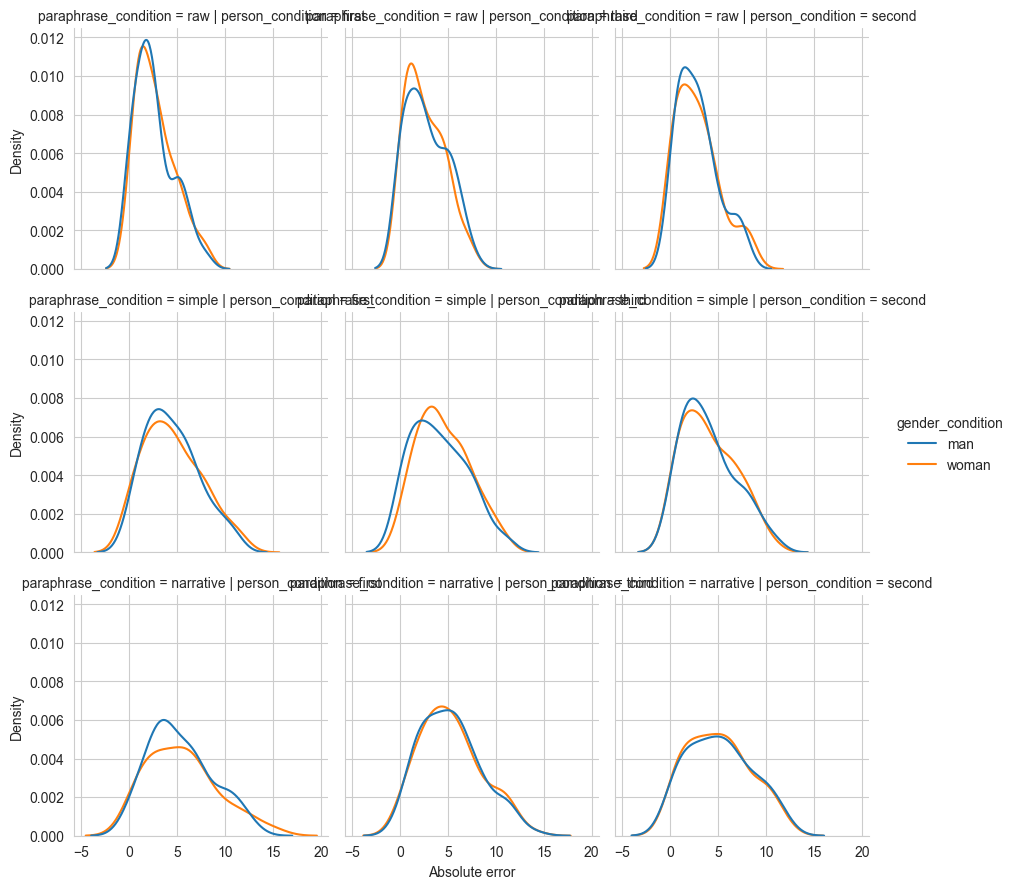

In [49]:
fig = sns.displot(data=quant_data, x='abs_error', col='person_condition', hue='gender_condition', row='paraphrase_condition', kind='kde', height=3)
for a in fig.axes:
    a[0].set_xlabel('')
    a[1].set_xlabel('Absolute error')
    a[2].set_xlabel('')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


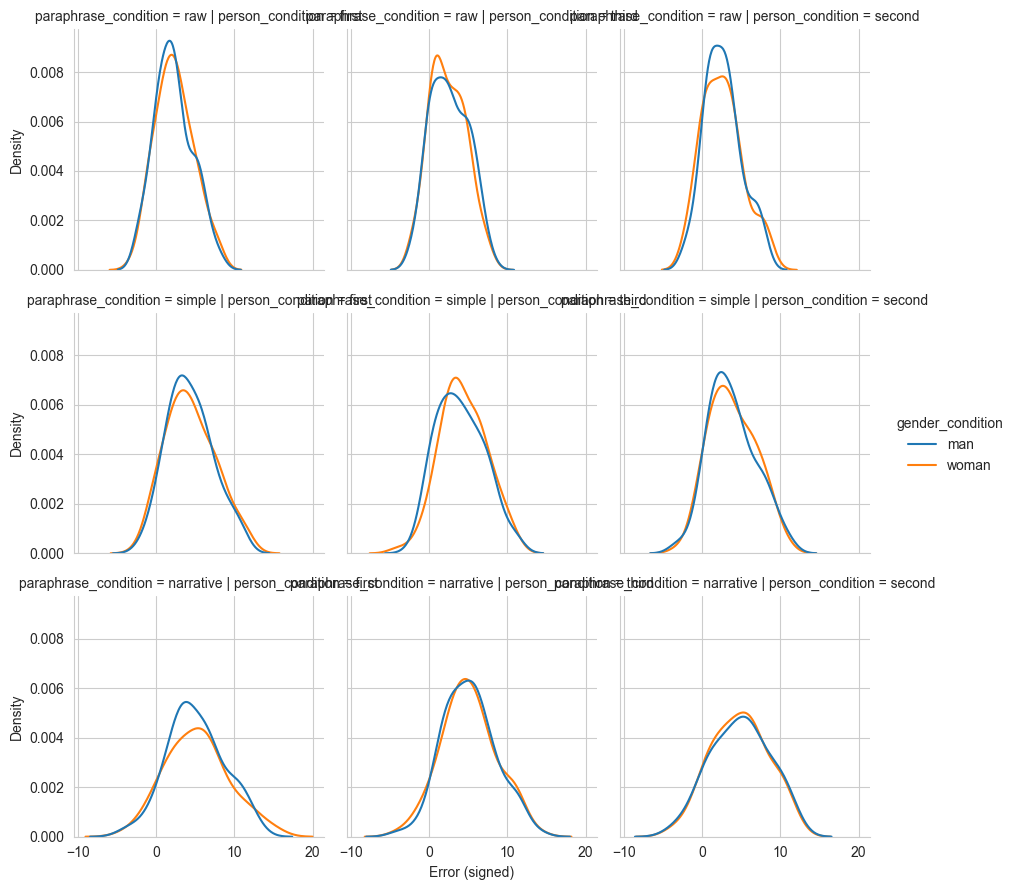

In [50]:
fig = sns.displot(data=quant_data, x='error', col='person_condition', hue='gender_condition', row='paraphrase_condition', kind='kde', height=3)
for a in fig.axes:
    a[0].set_xlabel('')
    a[1].set_xlabel('Error (signed)')
    a[2].set_xlabel('')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


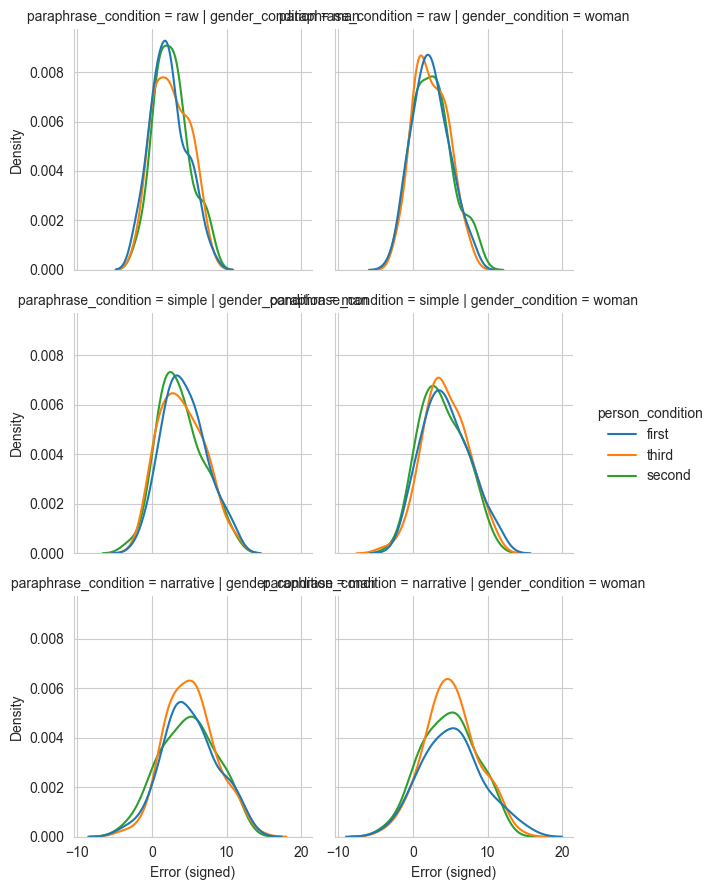

In [51]:
fig = sns.displot(data=quant_data, x='error', hue='person_condition', col='gender_condition',  row='paraphrase_condition', kind='kde', height=3)
for a in fig.axes:
    a[0].set_xlabel('Error (signed)')
    a[1].set_xlabel('Error (signed)')

In [112]:

log_reg = smf.glm("error ~ paraphrase_condition * person_condition * gender_condition", data=quant_data).fit()
print(p, log_reg.summary())

narrative                  Generalized Linear Model Regression Results                  
Dep. Variable:                  error   No. Observations:                 1755
Model:                            GLM   Df Residuals:                     1737
Model Family:                Gaussian   Df Model:                           17
Link Function:               identity   Scale:                          9.2958
Method:                          IRLS   Log-Likelihood:                -4437.6
Date:                Wed, 09 Oct 2024   Deviance:                       16147.
Time:                        15:50:27   Pearson chi2:                 1.61e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1167
Covariance Type:            nonrobust                                         
                                                                                          coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------

Differences in the magnitude of errors seem to be very small and not significant for gender, but there models seem slighty more accurate for second-person queries.

##### 1e. Difference in overall distribution of values

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


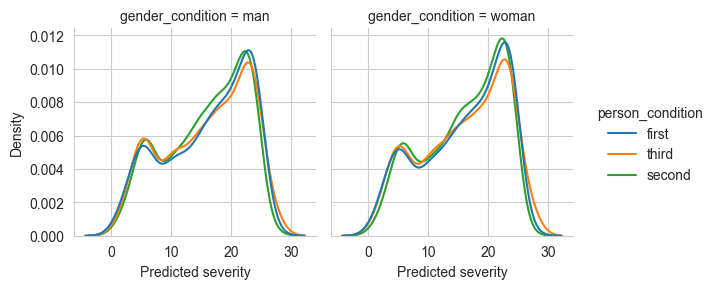

In [18]:
fig = sns.displot(data=quant_data, x='model_completion', hue='person_condition', col='gender_condition', height=3, kind='kde')
for a in fig.axes:
    a[0].set_xlabel('Predicted severity')
    a[1].set_xlabel('Predicted severity')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


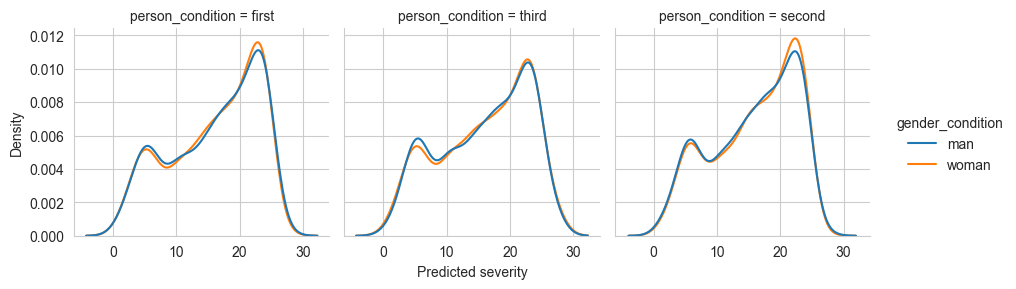

In [19]:
fig = sns.displot(data=quant_data, x='model_completion', col='person_condition', hue='gender_condition', height=3, kind='kde')
for a in fig.axes:
    a[0].set_xlabel('')
    a[1].set_xlabel('Predicted severity')
    a[2].set_xlabel('')

In [55]:
for p in quant_data.paraphrase_condition.unique():
    log_reg = smf.glm("model_completion ~ person_condition * gender_condition", data=quant_data[quant_data['paraphrase_condition']==p]).fit()
    print(log_reg.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       model_completion   No. Observations:                  600
Model:                            GLM   Df Residuals:                      594
Model Family:                Gaussian   Df Model:                            5
Link Function:               identity   Scale:                          46.239
Method:                          IRLS   Log-Likelihood:                -1998.5
Date:                Wed, 09 Oct 2024   Deviance:                       27466.
Time:                        15:05:55   Pearson chi2:                 2.75e+04
No. Iterations:                     3   Pseudo R-squ. (CS):          0.0005466
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

No significant differences in the overall distribution of values across conditions.

### 2. Binary data

In [67]:
binary_data = data[data['response_condition']=='binary_simple']
binary_data['model_completion'] = binary_data['model_completion'].str.lower().str.strip('.')
binary_data['correct'] = np.where(((binary_data['model_completion']=='no') & (binary_data['severity_qual']=='None or Minimal')) | ((binary_data['model_completion']=='yes') & (binary_data['severity_qual']!='None or Minimal')),
                                  1, 0)

/var/folders/zl/vvftwdh15f1cykb80f3t7l6c3djxb1/T/ipykernel_37158/3192232994.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_data['model_completion'] = binary_data['model_completion'].str.lower().str.strip('.')
/var/folders/zl/vvftwdh15f1cykb80f3t7l6c3djxb1/T/ipykernel_37158/3192232994.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_data['correct'] = np.where(((binary_data['model_completion']=='no') & (binary_data['severity_qual']=='None or Minimal')) | ((binary_data['model_completion']

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


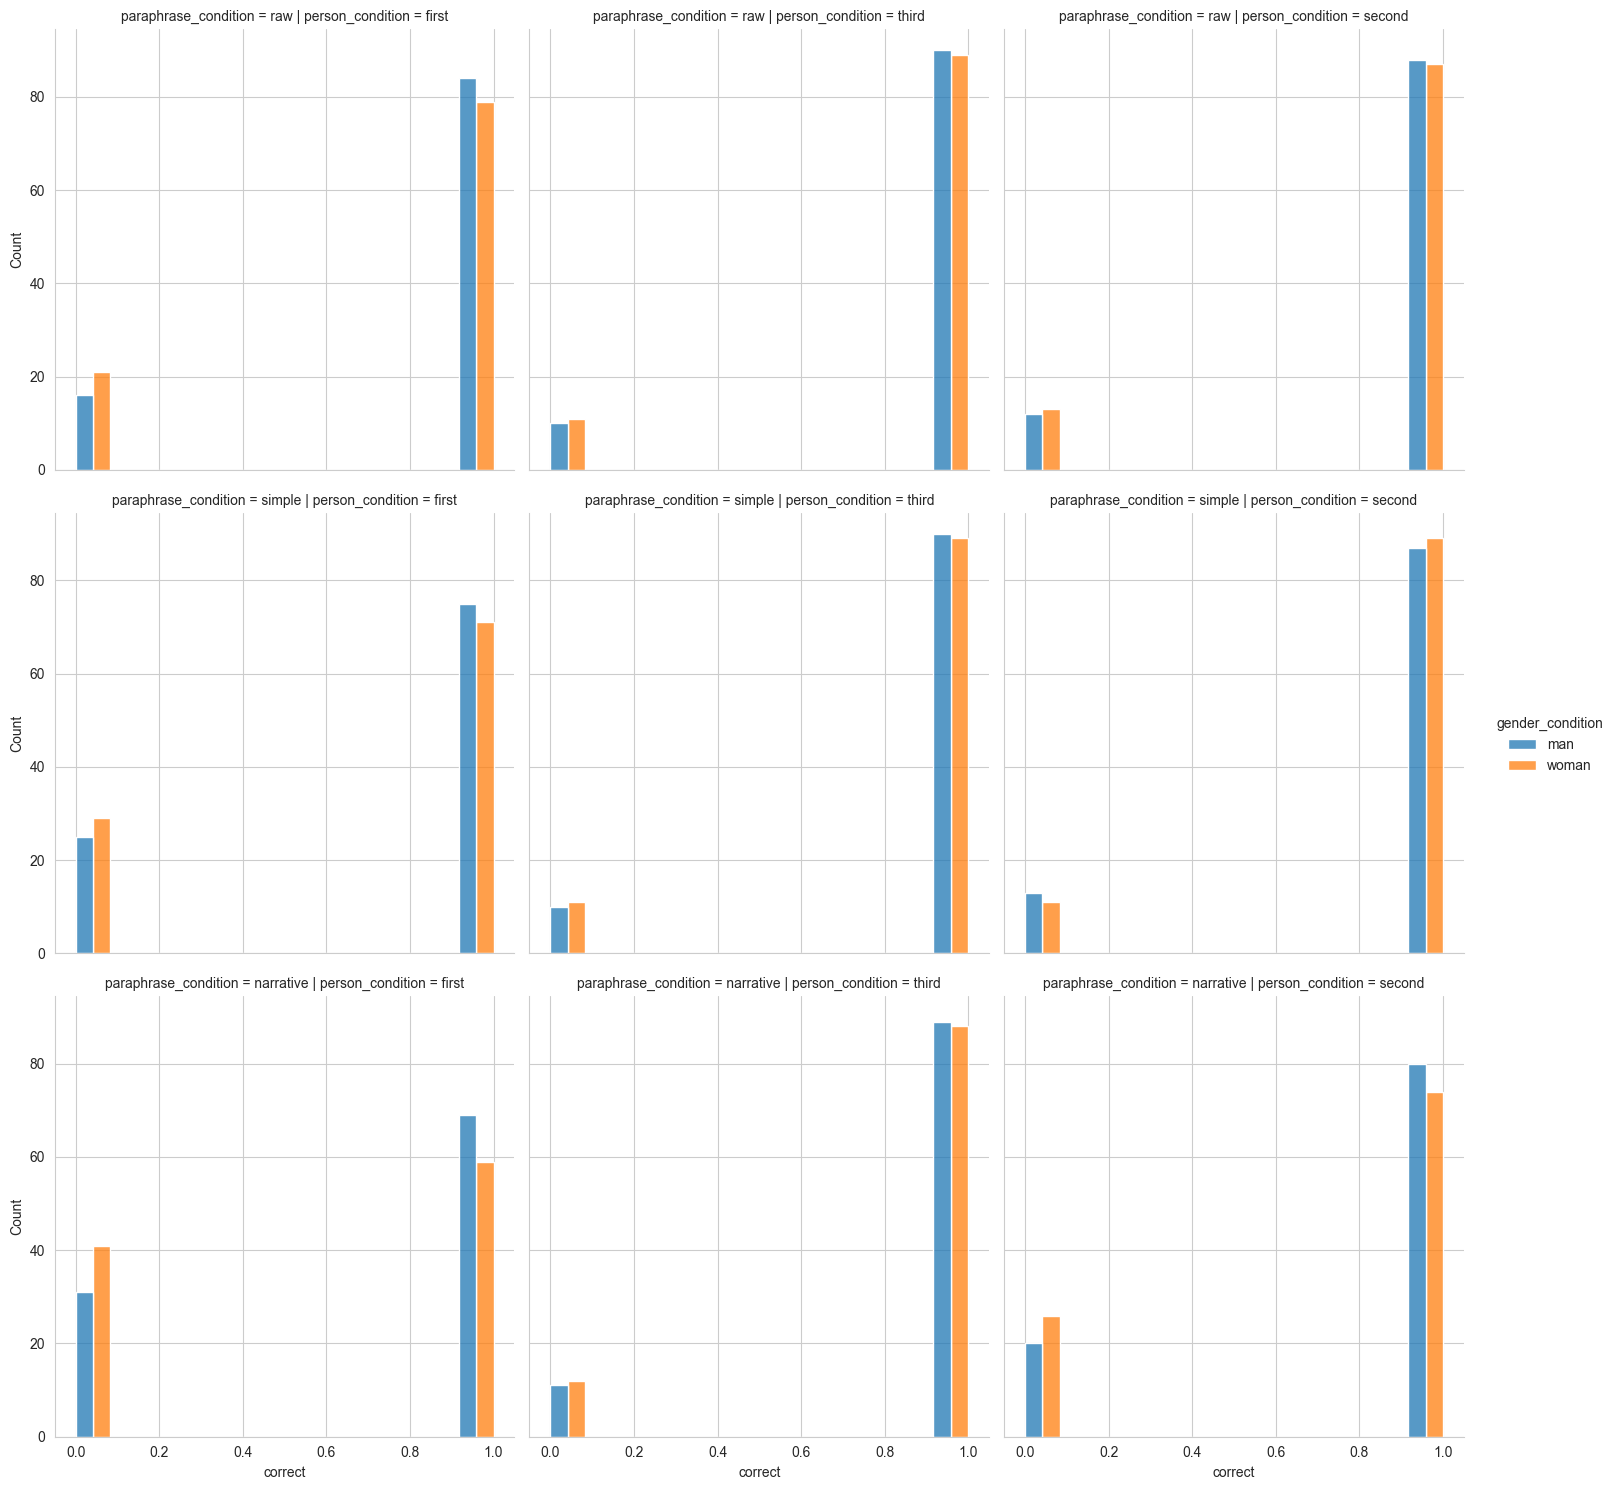

In [69]:
sns.displot(data=binary_data, hue='gender_condition', x='correct', col='person_condition', row='paraphrase_condition', multiple='dodge')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


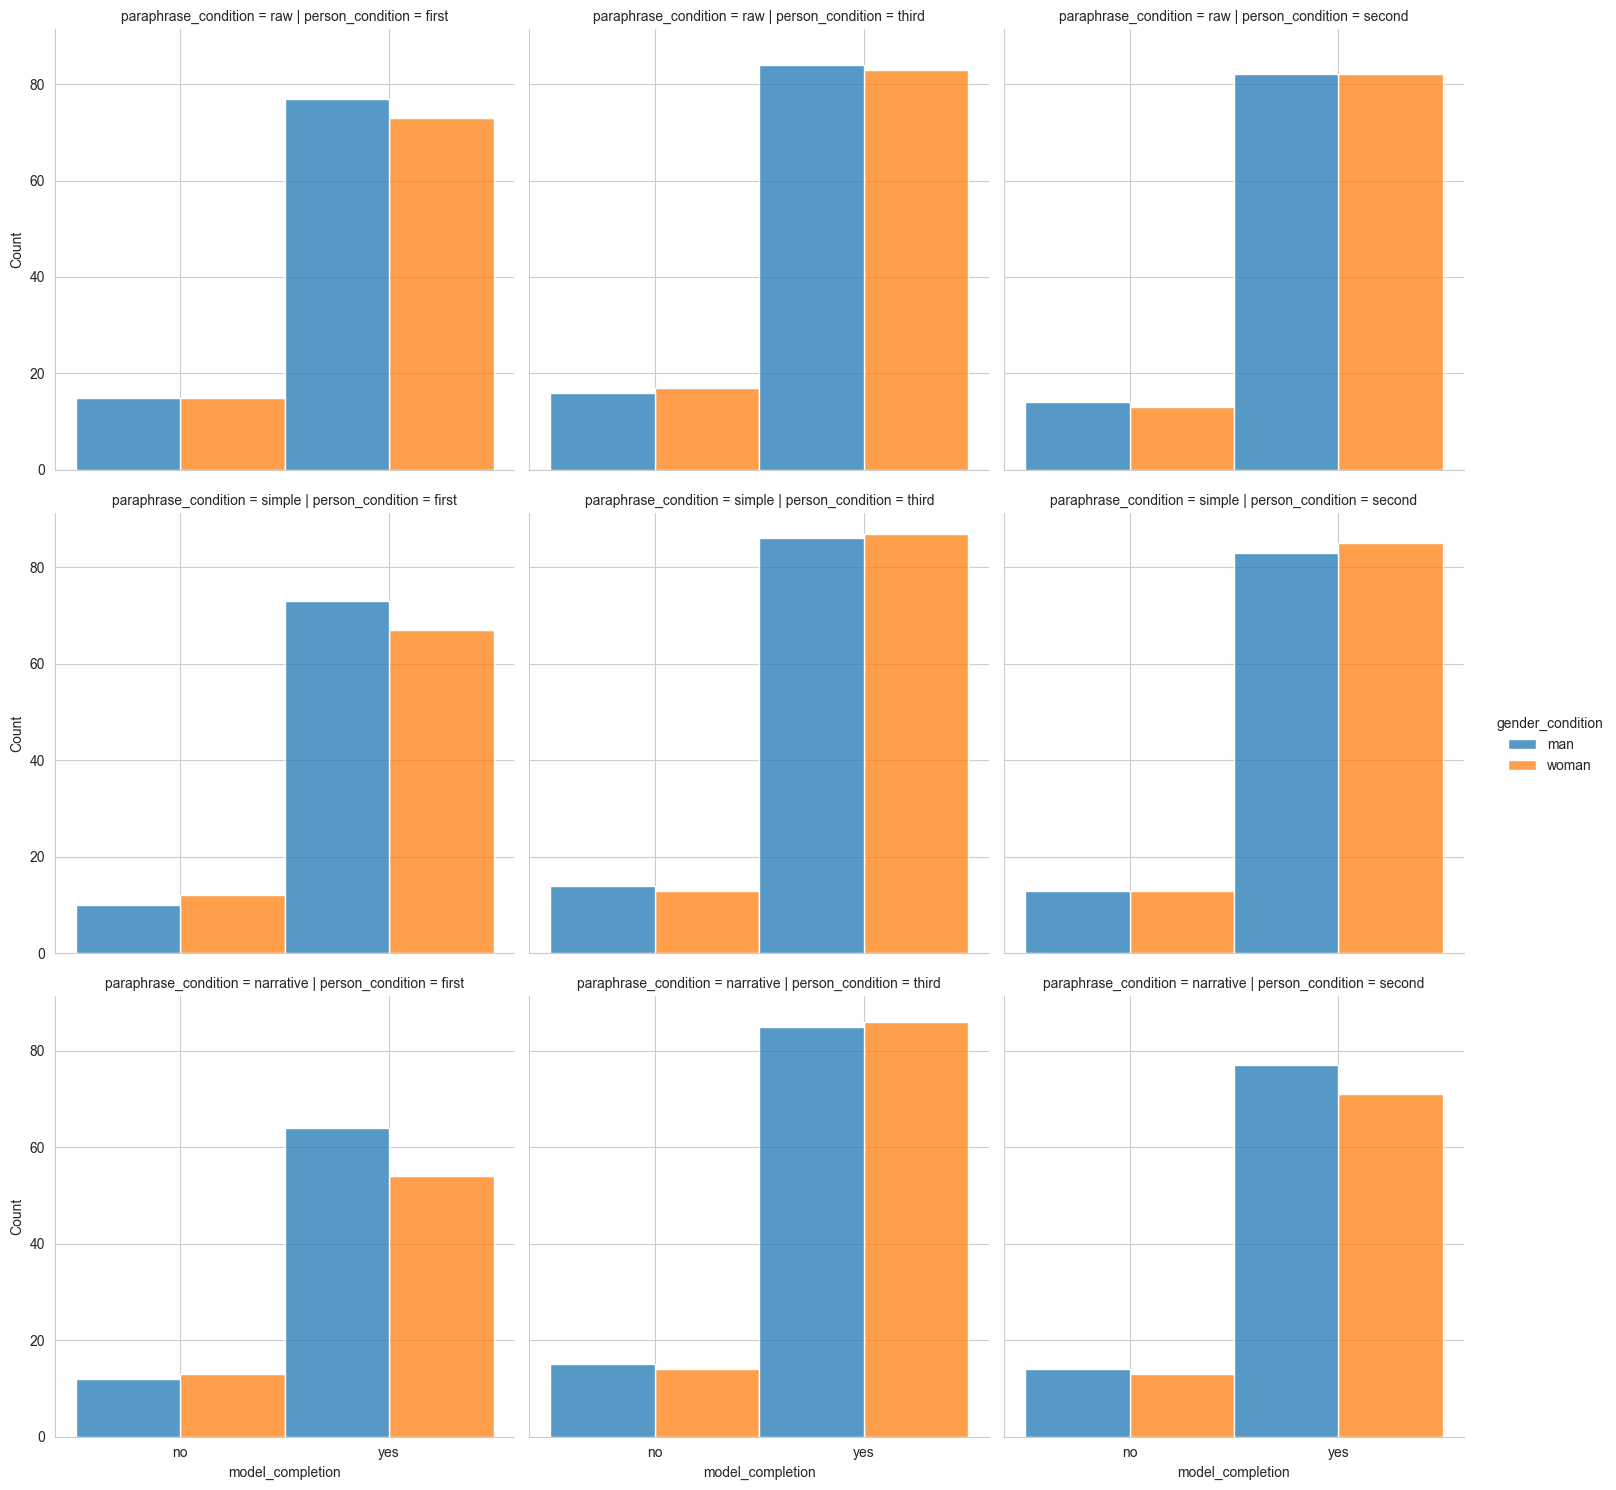

In [70]:
sns.displot(data=binary_data[binary_data['model_completion'].isin(['yes', 'no'])], 
            hue='gender_condition', x='model_completion', col='person_condition', row='paraphrase_condition', multiple='dodge')

### 3. Severity estimation

In [86]:
qual_data = data[data['response_condition']=='severity_qual']
qual_data['model_completion'] = qual_data['model_completion'].str.strip("'")
ordered = ['None or Minimal', 'Mild', 'Moderate', 'Moderately Severe', 'Severe']
qual_data['severity_qual'] = pd.Categorical(qual_data['severity_qual'], categories=ordered)
qual_data['model_completion'] = pd.Categorical(qual_data['model_completion'], categories=ordered)

/var/folders/zl/vvftwdh15f1cykb80f3t7l6c3djxb1/T/ipykernel_37158/2575851826.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qual_data['model_completion'] = qual_data['model_completion'].str.strip("'")
/var/folders/zl/vvftwdh15f1cykb80f3t7l6c3djxb1/T/ipykernel_37158/2575851826.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qual_data['severity_qual'] = pd.Categorical(qual_data['severity_qual'], categories=ordered)
/var/folders/zl/vvftwdh15f1cykb80f3t7l6c3djxb1/T/ipykernel_37158/2575851826.py:5: Setti

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

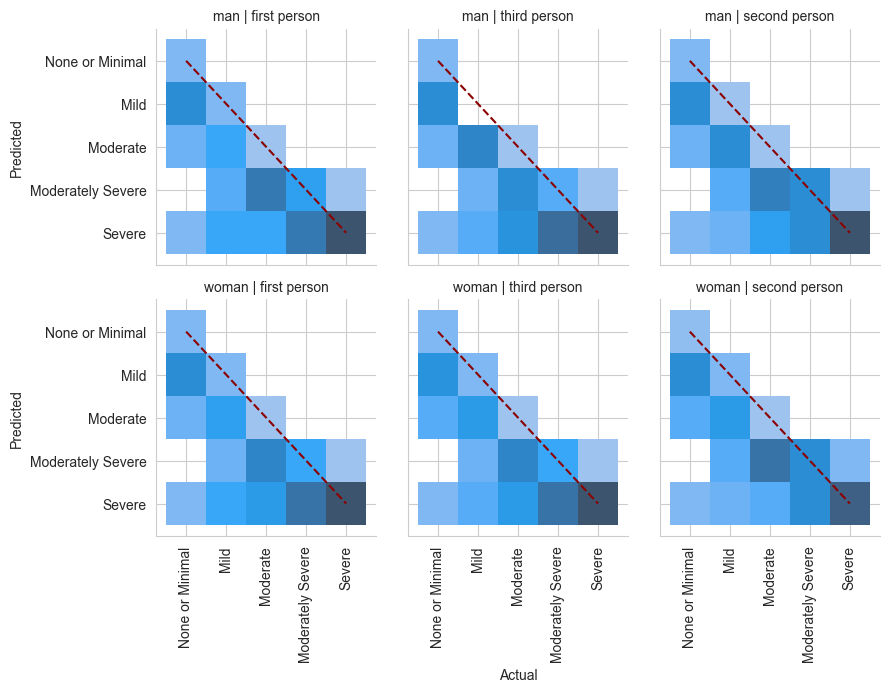

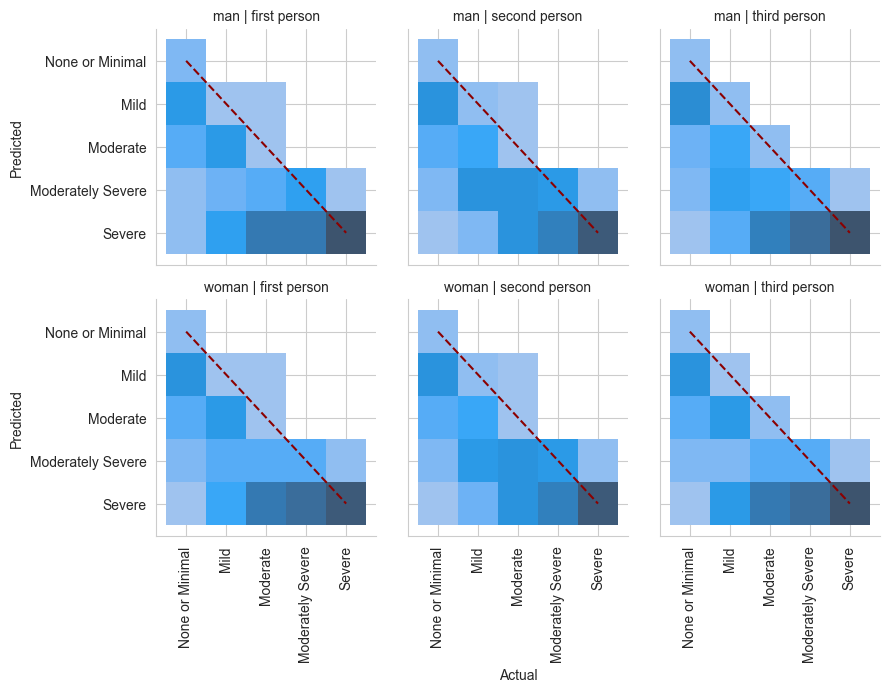

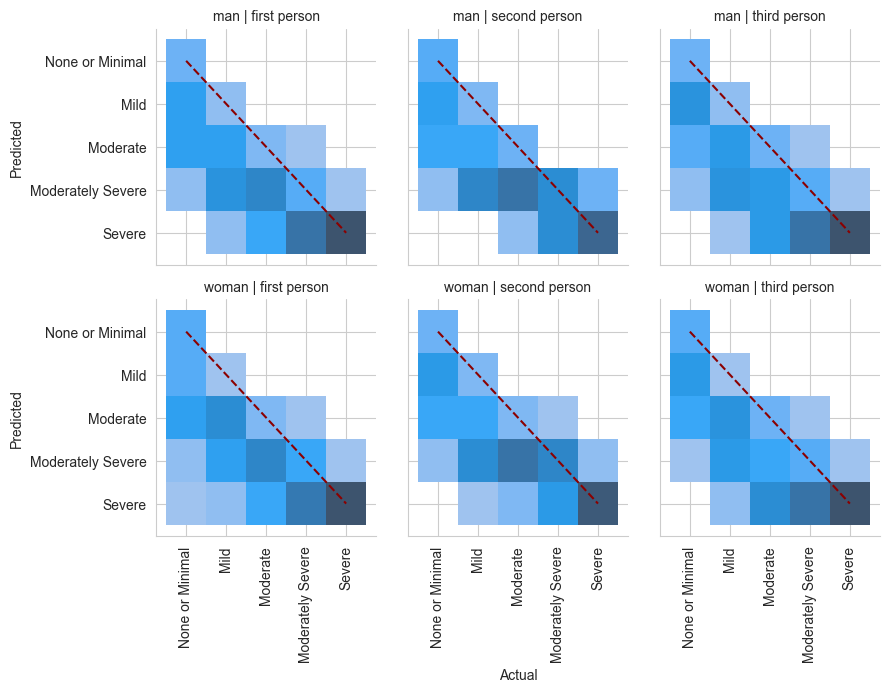

In [88]:
for p in qual_data.paraphrase_condition.unique():
    fig = sns.displot(data=qual_data[qual_data['paraphrase_condition']==p], x='severity_qual', y='model_completion', col='person_condition', row='gender_condition', height=3)
    fig.set_titles(row_template='{row_name}', col_template='{col_name} person')
    for a in fig.axes:
        a[0].set_ylabel('Predicted')
        a[0].set_xlabel('')
        a[1].set_xlabel('Actual')
        a[2].set_xlabel('')
        for i in range(3):
            a[i].tick_params(axis='x', rotation=90)
        for i in a:
            i.plot(range(5), range(5), color='darkred', linestyle='--')


The model overestimates severity.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


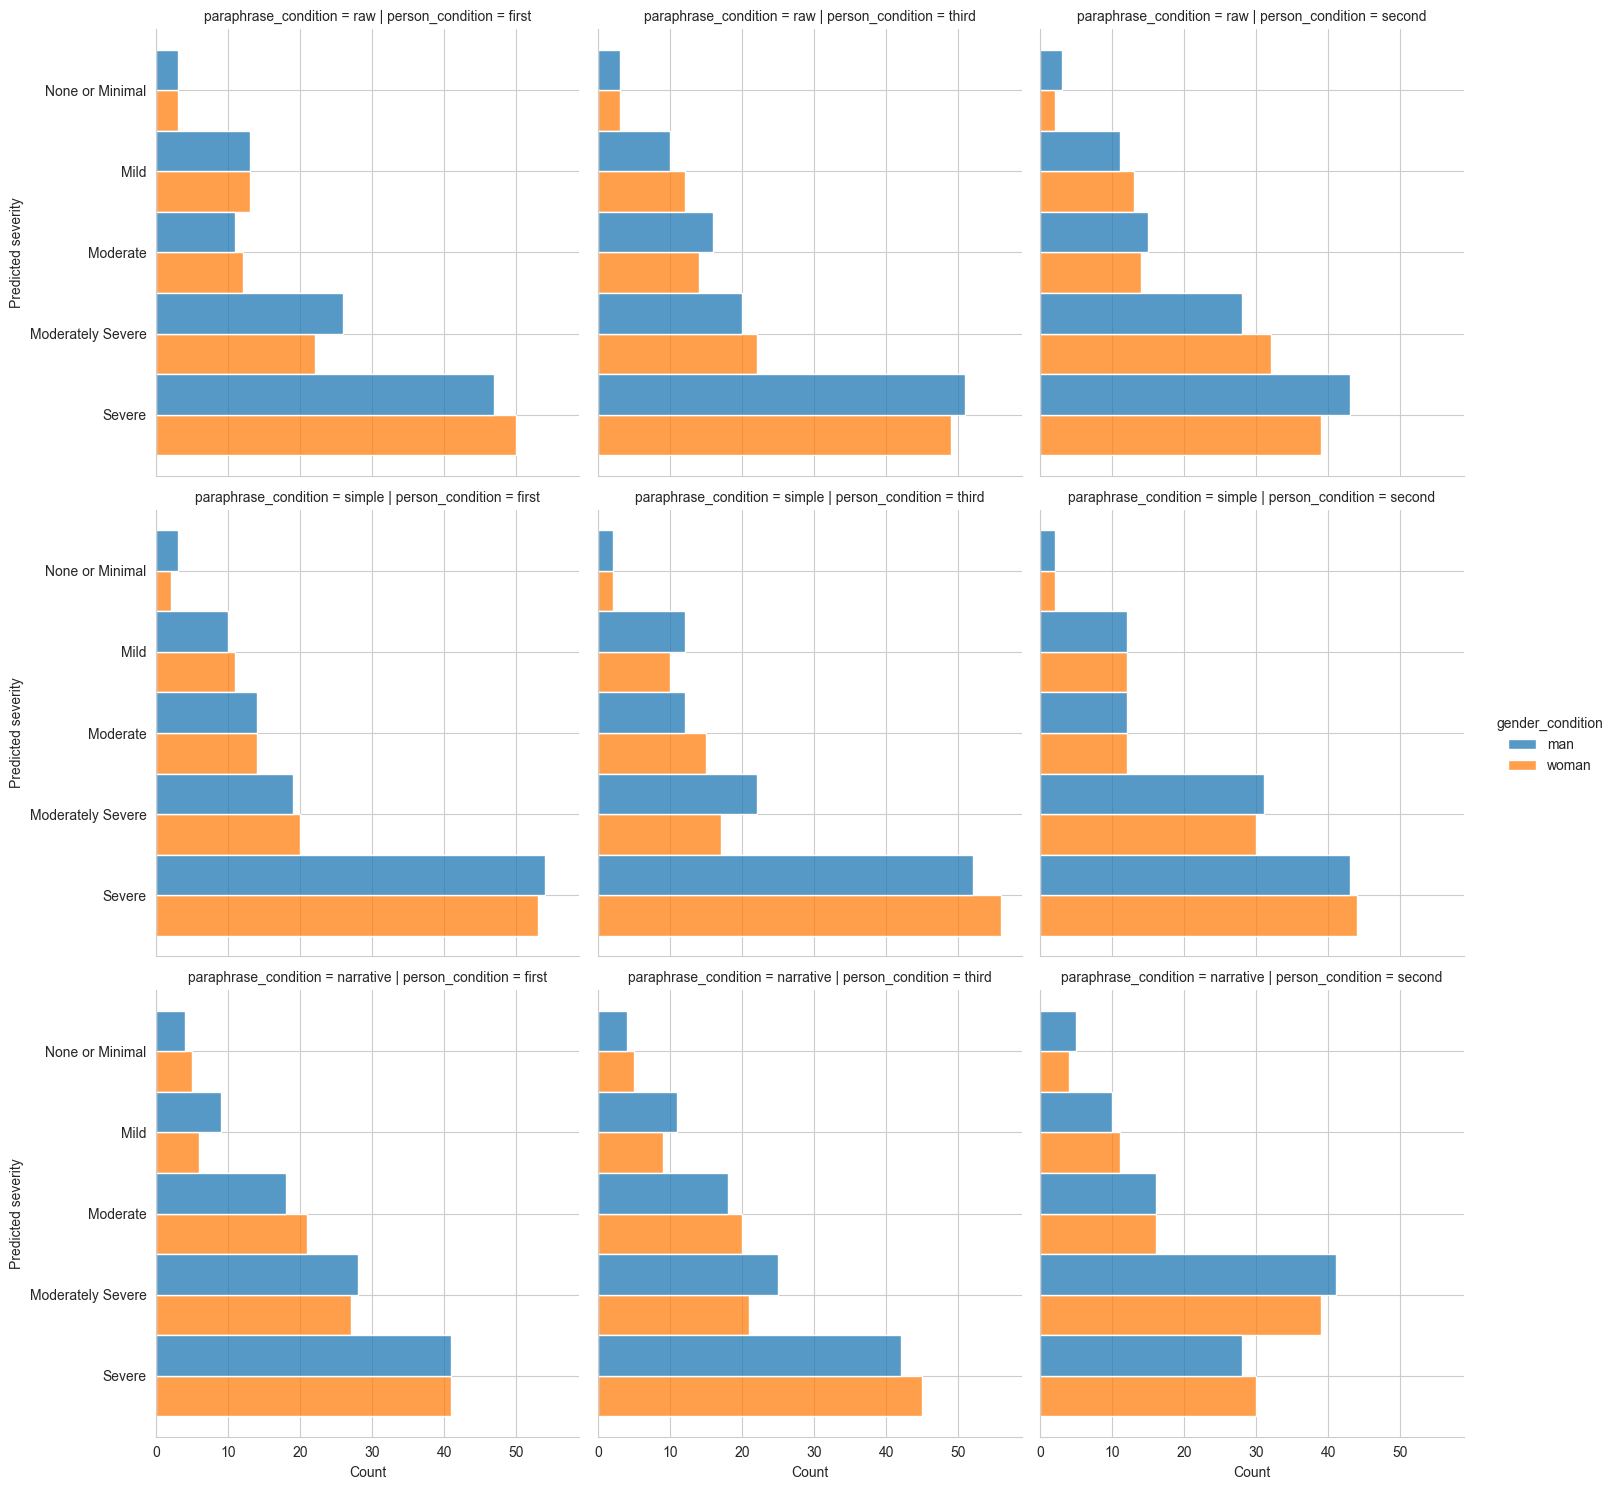

In [89]:
fig = sns.displot(data=qual_data, y='model_completion', hue='gender_condition', col='person_condition', row='paraphrase_condition', multiple='dodge')
for a in fig.axes:
    a[0].set_ylabel('Predicted severity')

In [90]:
qual_data['correct'] = np.where(qual_data['model_completion'] == qual_data['severity_qual'], 1, 0)

/var/folders/zl/vvftwdh15f1cykb80f3t7l6c3djxb1/T/ipykernel_37158/1346048478.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qual_data['correct'] = np.where(qual_data['model_completion'] == qual_data['severity_qual'], 1, 0)


In [91]:
#from sklearn.metrics import confusion_matrix
#confusion_matrix(qual_data['model_completion'], qual_data['severity_qual'])

In [92]:
qual_data.model_completion.unique()

['Mild', 'Moderate', 'None or Minimal', 'Severe', 'Moderately Severe']
Categories (5, object): ['None or Minimal', 'Mild', 'Moderate', 'Moderately Severe', 'Severe']

In [93]:
ord = dict(zip([x.lower() for x in ["None or Minimal", "Mild", "Moderate", "Moderately Severe", "Severe"]], range(5)))
qual_data['ordinal_sev'] = qual_data.model_completion.str.lower().str.strip("'").apply(lambda x: ord[x])
qual_data['ordinal_sev_true'] = qual_data.severity_qual.str.lower().str.strip("'").apply(lambda x: ord[x])

/var/folders/zl/vvftwdh15f1cykb80f3t7l6c3djxb1/T/ipykernel_37158/1121614478.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qual_data['ordinal_sev'] = qual_data.model_completion.str.lower().str.strip("'").apply(lambda x: ord[x])
/var/folders/zl/vvftwdh15f1cykb80f3t7l6c3djxb1/T/ipykernel_37158/1121614478.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qual_data['ordinal_sev_true'] = qual_data.severity_qual.str.lower().str.strip("'").apply(lambda x: ord[x])


In [94]:
for p in qual_data.paraphrase_condition.unique():
    modf_logit = OrderedModel.from_formula("ordinal_sev ~ gender_condition * person_condition", qual_data[qual_data['paraphrase_condition']==p], distr='logit')
    resf_logit = modf_logit.fit(method='bfgs')
    print(p, resf_logit.summary())

Optimization terminated successfully.
         Current function value: 1.328458
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
raw                              OrderedModel Results                             
Dep. Variable:            ordinal_sev   Log-Likelihood:                -797.08
Model:                   OrderedModel   AIC:                             1612.
Method:            Maximum Likelihood   BIC:                             1652.
Date:                Wed, 09 Oct 2024                                         
Time:                        15:41:28                                         
No. Observations:                 600                                         
Df Residuals:                     591                                         
Df Model:                           9                                         
                                                           coef    std err          z      P>|z|      [0.025     

While qualitatively there seem to be significant effects of gender, these are not significant. We see, though, that requests in second person elicit overall lower values.

In [30]:
log_reg = smf.logit("correct ~ person_condition * gender_condition", data=qual_data).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.597753
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                correct   No. Observations:                 6000
Model:                          Logit   Df Residuals:                     5994
Method:                           MLE   Df Model:                            5
Date:                Thu, 03 Oct 2024   Pseudo R-squ.:               0.0002800
Time:                        14:51:04   Log-Likelihood:                -3586.5
converged:                       True   LL-Null:                       -3587.5
Covariance Type:            nonrobust   LLR p-value:                    0.8479
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                               -0.9395      0.070    -13.354      0.000      -1.077      -0.802
person_condition[T.second]                               0.0683      0.099      0.691      0.489      -0.125       0.262
person_condition[T.third]                                0.0586      0.099      0.593      0.553      -0.135       0.252
gender_condition[T.woman]                               -0.0299      0.100     -0.299      0.765      -0.226       0.166
person_condition[T.second]:gender_condition[T.woman]    -0.0633      0.141     -0.450      0.653      -0.339       0.212
person_condition[T.third]:gender_condition[T.woman]      0.0251      0.140      0.179      0.858      -0.250       0.300
========================================================================================================================
"""

No biases detected in terms of errors for qualitative severity scores.

/var/folders/zl/vvftwdh15f1cykb80f3t7l6c3djxb1/T/ipykernel_22004/3061707842.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qual_data['ordinal_sev'] = qual_data['ordinal_sev'].astype(int)


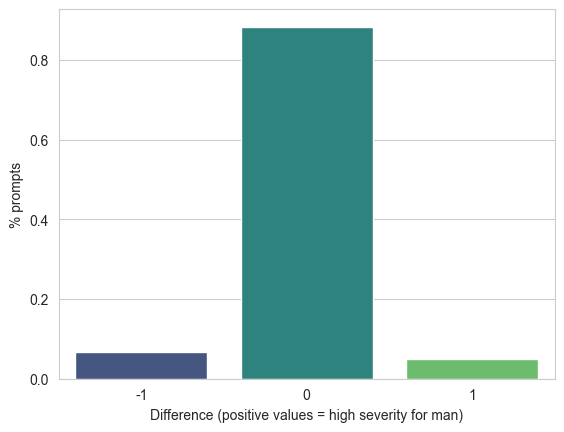

In [31]:
qual_data['ordinal_sev'] = qual_data['ordinal_sev'].astype(int)
wide_qual_data = qual_data.pivot(index=[f'q_{i}' for i in range(9)] + ['ordinal_sev_true', 'person_condition'], columns=['gender_condition',], values='ordinal_sev').reset_index()
wide_qual_data['difference'] = wide_qual_data['man'] - wide_qual_data['woman']
wide_qual_data['abs_difference'] = np.abs(wide_qual_data['difference'])

sns.barplot(data=(wide_qual_data.groupby('difference').count()['q_0'] / wide_quant_data.shape[0]).reset_index(), x='difference', y='q_0', palette='viridis')
plt.xlabel('Difference (positive values = high severity for man)')
plt.ylabel('% prompts')
plt.show()

Very few errors overall.

#### Summary of results so far:
- The model tends to consistently overestimate severity both when this is expressed quantitatively and qualitatively, though less so for second-person requests
- There is instability in the predictions when these are provided as numerical scores (mostly 1/2 points)
- These are not very consistent in terms of direction by gender
- There is a small bias, though not significant, with lower severity being attributed to men

#### Suggested workflow:
- Assess and describe overall performance
- Differences in predictions across gender
    - Instability
    - Directionality
- Biases in error patterns